In [9]:
pip install pytorch-msssim

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ssim
from PIL import Image
import matplotlib.pyplot as plt
import random

In [21]:
# Constants
IMG_SIZE = 60
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
NUM_EPOCHS = 25
LEARNING_RATE = 0.01
NUM_CLASSES = 400


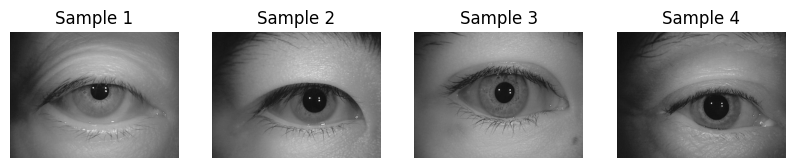

In [13]:
import random

class IrisDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

    def plot_samples(self, num_samples=4):
        # Check if the dataset is empty
        if len(self.image_paths) == 0:
            print("Dataset is empty. Cannot plot samples.")
            return

        # Ensure num_samples is not larger than the population
        num_samples = min(num_samples, len(self.image_paths))

        # Randomly select num_samples images
        sample_paths = random.sample(self.image_paths, num_samples)

        # Plot the selected images
        plt.figure(figsize=(10, 8))
        for i, img_path in enumerate(sample_paths):
            plt.subplot(1, num_samples, i + 1)
            image = Image.open(img_path).convert('L')
            plt.imshow(image, cmap='gray')
            plt.title(f'Sample {i + 1}')
            plt.axis('off')
        plt.show()

# Example usage:
root_dir = '/kaggle/input/lamp-iris'
transform = transforms.ToTensor()  # You can add other transformations here if needed
iris_dataset = IrisDataset(root_dir, transform)

# Plot 4 random samples
iris_dataset.plot_samples(num_samples=4)


In [15]:
# Transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])



In [16]:
# Autoencoder definition
class SimpleConvAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [17]:
# Loss class
class OpenSetLoss(nn.Module):
    def _init_(self):
        super(OpenSetLoss, self)._init_()

    def forward(self, outputs, targets):
        return F.mse_loss(outputs, targets)


In [ ]:
# Dataset and DataLoader initialization
dataset = IrisDataset('/kaggle/input/lamp-iris', transform=transform)
train_size = int((1 - VALIDATION_SPLIT) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [19]:
# Model, loss, and optimizer
model = SimpleConvAutoencoder()
criterion = OpenSetLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training and validation
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []


In [22]:
# Training 
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, train_accuracy = 0.0, 0.0
    for images in train_loader:
        images = images.float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_accuracy += ssim(outputs, images, data_range=1, size_average=True).item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')


    




Epoch 1/25, Training Loss: 0.0017, Training Accuracy: 0.8449
Epoch 2/25, Training Loss: 0.0006, Training Accuracy: 0.9107
Epoch 3/25, Training Loss: 0.0005, Training Accuracy: 0.9220
Epoch 4/25, Training Loss: 0.0004, Training Accuracy: 0.9283
Epoch 5/25, Training Loss: 0.0004, Training Accuracy: 0.9320
Epoch 6/25, Training Loss: 0.0004, Training Accuracy: 0.9359
Epoch 7/25, Training Loss: 0.0004, Training Accuracy: 0.9381
Epoch 8/25, Training Loss: 0.0003, Training Accuracy: 0.9395
Epoch 9/25, Training Loss: 0.0003, Training Accuracy: 0.9417
Epoch 10/25, Training Loss: 0.0003, Training Accuracy: 0.9437
Epoch 11/25, Training Loss: 0.0003, Training Accuracy: 0.9448
Epoch 12/25, Training Loss: 0.0003, Training Accuracy: 0.9454
Epoch 13/25, Training Loss: 0.0003, Training Accuracy: 0.9465
Epoch 14/25, Training Loss: 0.0003, Training Accuracy: 0.9469
Epoch 15/25, Training Loss: 0.0003, Training Accuracy: 0.9471
Epoch 16/25, Training Loss: 0.0003, Training Accuracy: 0.9478
Epoch 17/25, Trai

In [23]:
model.eval()
val_loss, val_accuracy = 0.0, 0.0
with torch.no_grad():
    for images in val_loader:
        images = images.float()
        outputs = model(images)
        loss = criterion(outputs, images)
        val_loss += loss.item() * images.size(0)
        val_accuracy += ssim(outputs, images, data_range=1, size_average=True).item() * images.size(0)
val_loss /= len(val_loader.dataset)
val_accuracy /= len(val_loader.dataset)
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)
print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 25/25, Validation Loss: 0.0003, Validation Accuracy: 0.9476


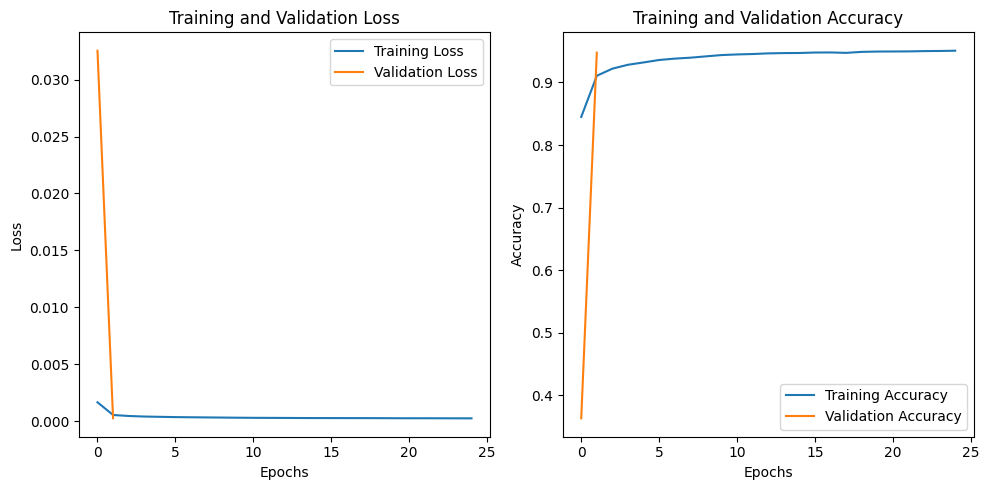

In [24]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
# Save model
torch.save(model.state_dict(), 'model.pth')
